In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_w, structure
from eigenwell.src.constants import *
import scipy.sparse.linalg as la

print(MU0)
print(EPSILON0)
print(C0)

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


/Users/nathanzhao/src/eigenwell/src/grid.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(dL)==len(N) == 2, 'must specify 2 elem arr even for 1d sims')


1.2566370614359173e-06
8.854e-12
299795637.69321626


## Analytic Solution


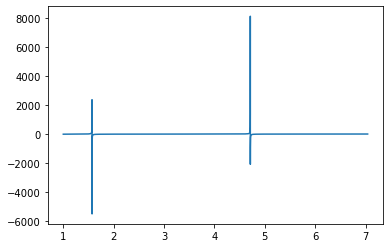

NameError: name 'nr' is not defined

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## calculates dispersion for a slab structure that looks like

def wg(kz, a, kz_max):
    '''
    waveguide transcendental equation (the return should equal 0 for a solution kz)
    :param kz: transverse wavevector
    :param a:  1/2 width of waveguide
    :param ei: slab dielectric
    :param e:  cladding dielectric
    :param kz_max: (k0**2*(e_i-e))
    :return:
    '''
    return np.tan(kz*a) - np.sqrt(kz_max**2 - kz**2)/kz

def deriv_wg(kz, a, kz_max):
    '''
    :param kz:
    :param a:
    :param kz_max:
    :return:
    '''
    sec = lambda arg: 1/np.cos(arg)**2;
    arg = np.sqrt(kz_max**2 - kz**2);
    return a*sec(kz)**2 - (-2*kz**2/arg - arg)/kz**2

def wg2(kzd, kz_max_d):
    '''
    :param kzd: kz*a transverse wavevector
    :param ei: slab dielectric
    :param e:  cladding dielectric
    :param kz_max_d: (k0**2*a**2*(e_i-e))
    :return:
    '''
    return np.tan(kzd) - np.sqrt(kz_max_d ** 2 - kzd ** 2) / kzd

def deriv_wg2(kz, kz_max):
    sec = lambda arg: 1/np.cos(arg)**2;
    arg = np.sqrt(kz_max**2 - kz**2);
    return sec(kz)**2 - (-2*kz**2/arg - arg)/kz**2


## specify waveguide problem
L0 = 1e-6;
ei = 3;
e = 1;
a = 1;
wvlen = 10**-0.2; k0 = 2*np.pi/wvlen;
kz_max = np.sqrt(k0**2*a**2*(ei - e));

kz_test = np.linspace(1, kz_max/2, 10000);
plt.figure();
plt.plot(kz_test, wg2(kz_test, kz_max));
plt.show();

kzn, history = nr.newton_root_args(wg2, deriv_wg2,  kz_max, x0=7.6, tol=1e-5, max_iter = 10000);
plt.plot(history);
plt.show();
print(kzn)
print(wg2(kzn, kz_max))

## do a scan of different frequencies

measured_beta = list();

# IF THE WVLEN IS TOO SMALL, THERE ARE TOO MANY POLES IN THE SCAN SPACE AND IT'S HARD TO GET A CLEAN SOLVE
wvlen_scan = np.linspace(2, 120, 700)

## need a good input guess in order to get the process started, so it's not a bad idea to look at the first wvlen
x0_guess =5

for lam0 in wvlen_scan :
    k0 = 2 * np.pi / lam0;
    kz_max = np.sqrt(k0 ** 2 * a ** 2 * (ei - e));

    #IF we return a NaN at any point, pick a different x_guess
    kzn, history = nr.newton_root_args(wg2, deriv_wg2, kz_max, x0=x0_guess, tol=1e-5, max_iter=10000);
    while(np.isnan(kzn)):
        x0_guess = np.random.rand();
        kzn, history = nr.newton_root_args(wg2, deriv_wg2, kz_max, x0=x0_guess, tol=1e-5, max_iter=10000);

    x0_guess = kzn;
    beta = np.sqrt(k0**2*ei - kzn**2);
    print(wg2(kzn,kz_max))
    measured_beta.append(beta);

measured_beta = np.array(measured_beta);
c0 = 3e8;
omega_scan = 2*np.pi*c0/wvlen_scan;
plt.plot(measured_beta, omega_scan, '.');
plt.plot(measured_beta, c0 * measured_beta);
plt.plot(measured_beta, c0 * measured_beta/np.sqrt(ei));

plt.show();


In [ ]:
## slabe mode solver functions
from scipy.optimize import root
import numpy as np

'''
functions to solve for the transcendental equation and reconstruct mode profiles for a 2d dielectric slab waveguide
'''

'''
In these functions, a is the waveguide HALF WIDTH, not the full width. 
so a corresponds to a waveguide that is 2a in width
'''
L0 = 1e-6;
mu0 = MU0*L0
eps0 = EPSILON0*L0
c0 = 1/sqrt(mu0*eps0)
epsilon_wg = 12;
epsilon_clad = 2;


def TE_even(k, a = 0.5, omega = 2*np.pi*c0/1.55, epsilon_wg = 6.25, epsilon_clad = 2.25):
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
    
def TE_odd(k, a = 0.5, omega = 2*np.pi*c0/1.55, epsilon_wg = 6.25, epsilon_clad = 2.25):
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
  
#ansr = root(TE_even,  initial_guess)
  
def construct_mode_TE(k, a, omega, epsilon_wg, epsilon_clad, wrange, parity = 'even'):
    beta = np.sqrt(omega**2*mu0*eps0*epsilon_wg - k**2);
    kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
    alpha = np.sqrt(kmax**2 - k**2)
    
    ## we need to know a priori from our problem set up how many grid points to do 
    wgx = np.linspace(-a, a, nwg);
    cladx_right = np.linspace(a, wrange[1], ncl//2+1)[1:];
    cladx_left = np.linspace(wrange[0], -a, ncl//2+2)[:-1]
    #assume Ey_eg coeff is 1
    if(parity == 'even'):
        Ey_wg = np.cos(k*wgx);
        Ey_clad_coeff = np.cos(k*a)/np.exp(-alpha*a);
    else:
        Ey_wg = np.sin(k*wgx);
        Ey_clad_coeff = np.sin(k*a)/np.exp(-alpha*a);

    Ey_clad_r = Ey_clad_coeff*np.exp(-alpha*cladx_right)
    Ey_clad_l = Ey_clad_coeff*np.exp(alpha*cladx_left)
    
    #Ey_wg, Ey_clad_l[:-1], Ey_clad_r[1:], wgx, cladx_left[:-1], cladx_right[1:];
    
    Ey_mode = np.concatenate((Ey_clad_l, Ey_wg, Ey_clad_r))
    xscan = np.concatenate((cladx_left, wgx, cladx_right))
    
    return xscan, Ey_mode, beta, kmax, alpha;

''' code snippet for calculating the bandstructure'''
## band structure scan using the band solver
import math
wvlen_scan = np.linspace(0.5,30,100);
wvlen_scan = np.logspace(np.log10(0.75), np.log10(30), 500);
omega_scan = 2*np.pi*c0/wvlen_scan;
## betax=2.422;%2.422;%2.179; #but we are solving for not betax, but k (or really kz)
for initial_guess in [0.2,4, 6]: ## warning higher order modes have CUTOFFS
    beta_data = list();
    odd_beta = list();
    ## DO THE TE even MODE
    for w in omega_scan:
        #does TE have a cutoff frequency, no, it shouldn't.
        def TE_even(k, a = 0.5, omega = w, epsilon_wg = 6.25, epsilon_clad = 2.25):
            kmax = np.sqrt(w**2*mu0*eps0*(epsilon_wg-epsilon_clad));
            return np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
        
        kmax = np.sqrt(w**2*mu0*eps0*(epsilon_wg-epsilon_clad));
        ansr = root(TE_even,  initial_guess)
        if(not ansr.success):
            beta_data.append(0);
            continue;
        #print(ansr.x[0])
        kans = ansr.x[0];

        alpha = np.sqrt(kmax**2 - kans**2)
        #beta = np.sqrt(w**2*mu0*eps0*epsilon_clad + alpha**2);
        beta_check = np.sqrt(w**2*mu0*eps0*epsilon_wg-kans**2);
        beta_data.append(beta_check);
    
    ## DO THE TE ODD MODE
    for w in omega_scan:
        def TE_odd(k, a = 0.5, omega = w, epsilon_wg = 6.25, epsilon_clad = 2.25):
            kmax = np.sqrt(omega**2*mu0*eps0*(epsilon_wg-epsilon_clad));
            return -1/np.tan(k*a) - np.sqrt(kmax**2*a**2 - (k*a)**2)/(k*a)
        ansr_odd = root(TE_odd,  initial_guess)
        if(not ansr_odd.success):
            odd_beta.append(0);
            continue;        
            
        kans = ansr_odd.x[0];
        alpha = np.sqrt(kmax**2 - kans**2)
        #beta = np.sqrt(w**2*mu0*eps0*epsilon_clad + alpha**2);
        beta = np.sqrt(w**2*mu0*eps0*epsilon_wg-kans**2);
        odd_beta.append(beta);
        
    beta_data = np.array(beta_data)
    plt.plot( omega_scan/(2*np.pi*c0), beta_data, '.b', markersize = 0.5)
    odd_beta = np.array(odd_beta);
 
    plt.plot( omega_scan/(2*np.pi*c0), odd_beta, '.g', markersize = 0.5)
  
    plt.ylabel('beta')
    plt.xlabel('omega')
    
plt.plot(omega_scan/(2*np.pi*c0), 1.5*omega_scan/(c0))
plt.plot( omega_scan/(2*np.pi*c0), 2.5*omega_scan/(c0))
plt.show();

## 2D simulation of slab waveguide

In [ ]:
def domain_with_pml(xrange, yrange, N, Npml):
    # %% Input parameters
    # % xrange: [xmin xmax], range of domain in x-direction without PML
    # % yrange: [ymin ymax], range of domain in y-direction without PML
    # % N: [Nx Ny], numbers of cells in x- and y-directions without PML
    # % Npml: [Nx_pml Ny_pml], numbers of cells in the x- and y-normal PML

#     %% Output parameters
#     % xrange: [xmin xmax], updated range of domain in x-direction including PML thickness
#     % yrange: [ymin ymax], updated range of domain in y-direction including PML thickness
#     % N: updated numbers of cells in the x- and y-directions including cells in PML
#     % dL: [dx dy], cell sizes
#     % Lpml: [Lx_pml Ly_pml], thicknesses of x- and y-normal PML

    L = [np.diff(xrange),np.diff(yrange)];  #% [Lx Ly]
    dL = L/N;  #% [dx dy]

    Lpml = Npml* dL;  #% [Lx_pml, Ly_pml]
    xrange = xrange + np.array([-1, 1]) * Lpml[0];  #% [xmin xmax] is updated
    yrange = yrange + np.array([-1, 1]) * Lpml[1];  #% [ymin ymax] is updated

    N = N + 2*Npml;  #% [Nx Ny] is updated
    
    return xrange, yrange, N, dL, Lpml;

In [7]:
xrange = 0.1*np.array([-1,1])*1e-6;  # x boundaries in L0
yrange = 0.8*np.array([-1,1])*1e-6;  # y boundaries in L0
L = np.array([np.diff(xrange)[0], np.diff(yrange)[0]]);
N = np.array([100, 500]);  #% [Nx Ny]
Npml = np.array([0, 15]);  #% [Nx_pml Ny_pml]
dL = L/N;
print(L)

[2.0e-07 1.6e-06]


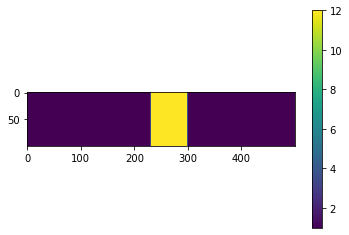

In [8]:
epsilon = np.ones(N);

epsilon[:,15+250-34:15+250+34]= 12;

plt.figure();
plt.imshow(epsilon);
plt.colorbar();


[2.0e-07 1.6e-06]
[2.0e-07 1.6e-06]
(100, 500) [2.0e-09 3.2e-09]


/Users/nathanzhao/src/eigenwell/src/pml.py:41: RuntimeWarning: divide by zero encountered in true_divide
  sigma_max = self.sigma_max / d_pml; #usually the pml is the same thickness on both sides


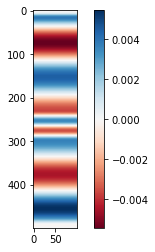

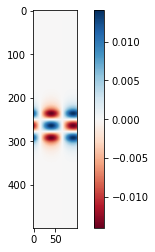

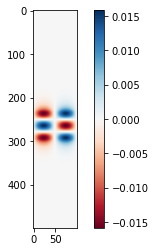

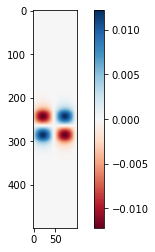

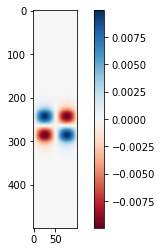

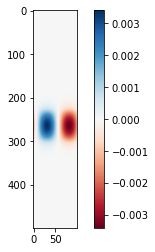

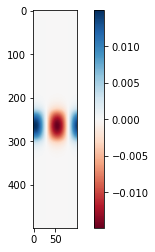

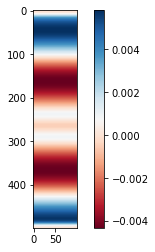

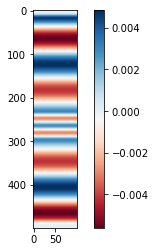

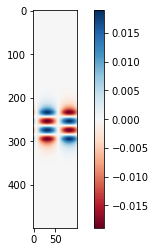

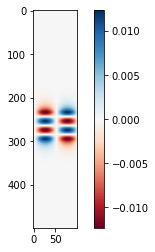

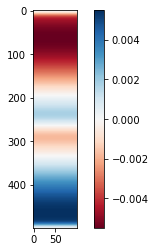

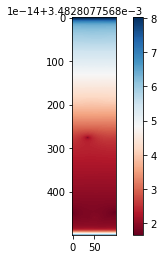

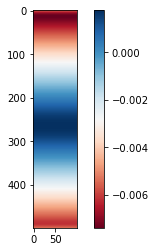

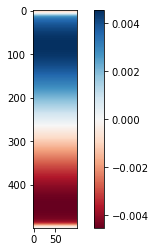

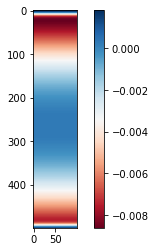

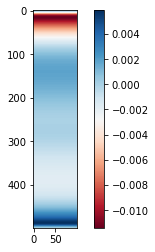

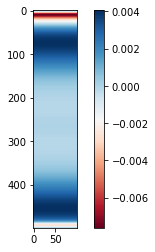

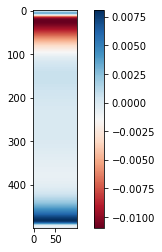

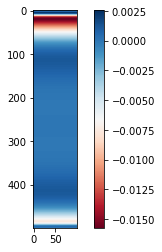

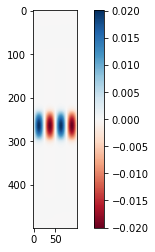

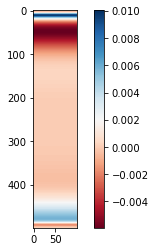

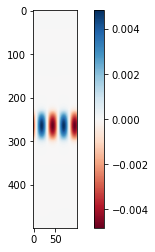

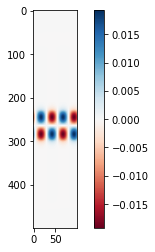

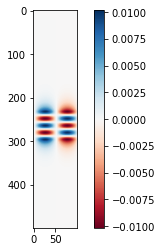

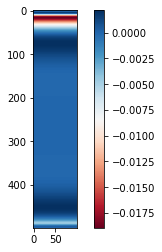

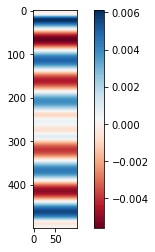

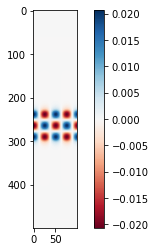

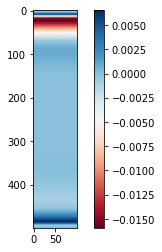

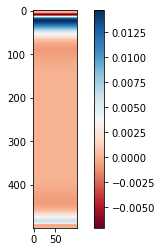

In [9]:
print(L)
st = structure.Structure(epsilon, L)
print(st.L)
print(st.N, st.dL)

omega = 2*np.pi*C0/(0.5e-6)
eigenTE = eigen_w.EigenOmega2D(st, npml = [0,30], omega_guess = omega, polarization= 'TE')# don't expose the finite difference class

A = eigenTE.A;
K =30
eigenvals, eigenmodes = la.eigs(A, k=K, sigma = omega**2)

for i in range(K):
    plt.imshow(np.real(eigenmodes[:,i].reshape(N, order = 'F')).T,cmap = 'RdBu')
    #plt.clim(-0.02, 0.02)
    plt.colorbar();
    plt.show();